In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
    auc,
)
from sklearn.preprocessing import label_binarize
from tabulate import tabulate

%matplotlib inline
matplotlib.rcParams.update({'font.size': 15})


In [3]:
df = pd.read_csv("../data/resnet/predictions.csv")
df.head()

,y_true,y_pred,y_pred_class_0,y_pred_class_1,y_pred_class_2
0,2,2,0.000055,0.028732,0.971213
1,2,2,0.000027,0.002377,0.997596
2,1,1,0.005354,0.989578,0.005068
3,1,1,0.000097,0.686545,0.313358
4,0,0,0.650661,0.337577,0.011762


In [4]:
accuracy = accuracy_score(
    y_true=df["y_true"],
    y_pred=df["y_pred"],
)
f1 = f1_score(
    y_true=df["y_true"],
    y_pred=df["y_pred"],
    average="weighted",
)
precision = precision_score(
    y_true=df["y_true"],
    y_pred=df["y_pred"],
    average="weighted",
)
recall = recall_score(
    y_true=df["y_true"],
    y_pred=df["y_pred"],
    average="weighted",
)
data = [
    ["Metric", "Value"],
    ["Accuracy", accuracy],
    ["F1 weighted",  f1],
    ["Precision weighted",  precision],
    ["Recall weighted",  recall],
]
table = tabulate(data, headers="firstrow", tablefmt="grid")
print(table)

+--------------------+----------+
| Metric             |    Value |
+====================+==========+
| Accuracy           | 0.922667 |
+--------------------+----------+
| F1 weighted        | 0.922894 |
+--------------------+----------+
| Precision weighted | 0.923356 |
+--------------------+----------+
| Recall weighted    | 0.922667 |
+--------------------+----------+


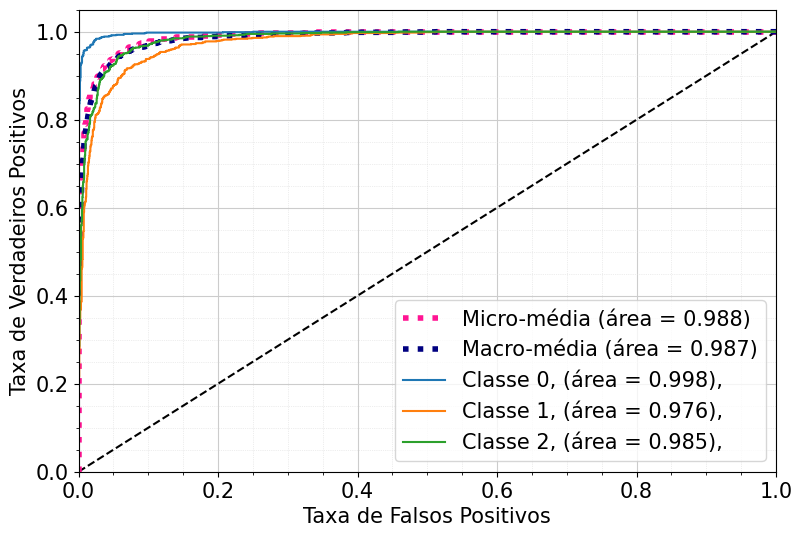

In [10]:
def plot_multiclass_roc(y_true, y_pred, y_proba, n_classes, figsize=(9, 6)):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_test = label_binarize(y_true, classes=np.arange(n_classes))

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_proba[:, i], drop_intermediate=False)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Taxa de Falsos Positivos')
    ax.set_ylabel('Taxa de Verdadeiros Positivos')
    # ax.set_title('Curva ROC')
    ax.plot(
        fpr["micro"],
        tpr["micro"],
        label="Micro-média (área = {0:0.3f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )
    ax.plot(
        fpr["macro"],
        tpr["macro"],
        label="Macro-média (área = {0:0.3f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='Classe %d, (área = %0.3f), ' % (i, roc_auc[i]))
    ax.legend(loc="best")
    ax.grid(which='major', color='#CCCCCC', linewidth=0.8)
    ax.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    plt.savefig("../results/resnet_roc_curve.png")
    plt.show()

plot_multiclass_roc(
    y_true=df["y_true"].values,
    y_pred=df["y_pred"].values,
    y_proba=df.iloc[:, 2:].values,
    n_classes=3,
)